## Module 3 - In this jupyter notebook, perfomance indicators are calculated
* Step 3a - Set up: Import modules/libraries, inport data, create output folder
* Step 3b - Calculate uniformity
* Step 3c - Calculate efficiency (beneficial fraction)
* Step 3d - Calculate adquacy
* Step 3e - Calculate relative water deficit
**=====================================================================================================================**

![title](img/Fig3_1.png)

**=====================================================================================================================**
#### <span style='background :lightgreen' > References:
* Karimi, P., Bongani, B., Blatchford, M., and de Fraiture, C.: Global satellite-based ET products for the local level irrigation management: An application of irrigation performance assessment in the sugarbelt of Swaziland, Remote Sensing, 11, 705, 2019.
* Bastiaanssen, W. G., and Bos, M.: Irrigation performance indicators based on remotely sensed data: a review of literature, Irrigation and drainage systems, 13, 291-311, 1999.
* Bastiaanssen, W. G., Van der Wal, T., and Visser, T.: Diagnosis of regional evaporation by remote sensing to support irrigation performance assessment, Irrigation and Drainage Systems, 10, 1-23, 1996.

## Step 3a - Set up

## i) Import packages/libraries

In [1]:
!pip install rasterio
!pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.4 MB/s eta 0:00:00


In [13]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import rasterio as rio
import rioxarray as riox
import xarray as xr
from matplotlib import pyplot as plt

In [12]:
import os                                 # a module for interacting with the operating system
import sys
import glob                               # used to retrieve files/pathnames matching a specified pattern
import re                                 # re sub() module can be used to replace substring
import rioxarray as rio
import pandas as pd                       # to store and manipulate tabular data in rows of observations and columns of variables
import numpy as np                        # stands for 'Numerical Python, is a python library used for scientific computing with arrays
import calendar
import datetime
from matplotlib import pyplot as plt      # is a plotting library used for 2D graphics in python
from osgeo import gdal

## ii) Import the input data
* Seasonal T, AETI, ETp

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# get seasonal data
T_fhs    = glob.glob(r'/content/drive/MyDrive/WaPOR_IPA/Data/L3-T-season/*.tif')
AETI_fhs = glob.glob(r'/content/drive/MyDrive/WaPOR_IPA/Data/L3-AETI-season/*.tif')

## iii) Output folder: Make one or connect to the existing one

In [ ]:
# output_folder
output_folderBF = r'/content/drive/MyDrive/WaPOR_IPA/Data/3_BeneficialFraction'  # create output folder
output_folderAd = r'/content/drive/MyDrive/WaPOR_IPA/Data/3_Adequacy'  # create output folder

# Make one if the folder does not exit
if not os.path.exists(output_folderBF):
    os.makedirs(output_folderBF)
if not os.path.exists(output_folderAd):
    os.makedirs(output_folderAd)

## Step 3b - Calculate uniformity of water consumption
* Equity is defined as the coefficients of variation (CV) of seasonal ETa in the area of interest.
* It measures the evenness of the water supply in an irrigation scheme.
* Note: CV of 0 to 10% is good, 10 to 25% is fair and CV > 25% is poor uniformity (Bastiaanssen et al., 1996)
<br/>

In [ ]:
# Uniformity of water Consumption

for i in range(len(AETI_fhs)):
    with rio.open(AETI_fhs[i]) as dataset:
        AETI = dataset.read(1)  # Read the first band

    AETIm = np.nanmean(AETI)
    AETIsd = np.nanstd(AETI)

    CV_AETI = (AETIsd / AETIm) * 100

    # Identify the date from the file name
    date = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ')

    if CV_AETI < 10:
        U = 'Good Uniformity'
    elif 10 <= CV_AETI < 25:
        U = 'Fair Uniformity'
    else:
        U = 'Poor Uniformity'

    print('CV of AETI in', date, '=', round(CV_AETI, 1), ',', U)


CV of AETI in  season1 2020-10-01 to 2021-04-30 = 27.0 , Poor Uniformity


## Step 3c - Calculate efficiency (beneficial fraction)
* Beneficial fraction is the ratio of the water that is consumed as transpiration compared to overall field water consumption (ETa).
* $Beneficial fraction = \frac{T_a}{ET_a}$
* It is a measure of the efficiency of on farm water and agronomic practices in use of water for crop growth.

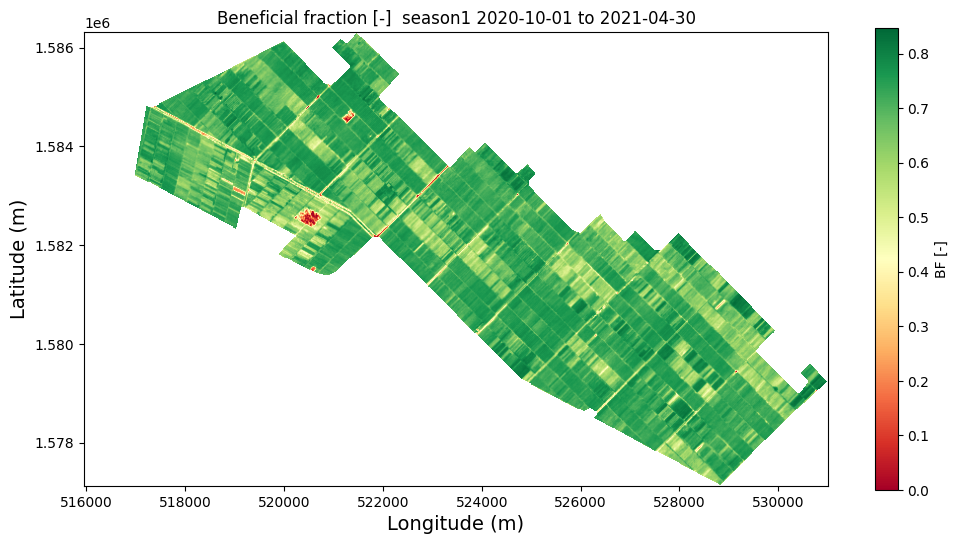

In [ ]:

for Tfh, ETfh in zip(T_fhs, AETI_fhs):
    try:
        T = riox.open_rasterio(Tfh)
        AETI = riox.open_rasterio(ETfh)

        T_over_AETI = T / AETI

        # Get spatial extent
        spatial_extent = (T_over_AETI.x.min(), T_over_AETI.x.max(), T_over_AETI.y.min(), T_over_AETI.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'BF')
        output_fn = os.path.join(output_folderBF, basename)
        T_over_AETI.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = T_over_AETI.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='BF [-]')
        plt.xlabel('Longitude (m)', fontsize=14)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=14)
        plt.title('Beneficial fraction [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")



## Step 3d - Calculate adequacy (relative evapotranspiration)
$Adequacy= \frac{ET_a}{ET_p}$

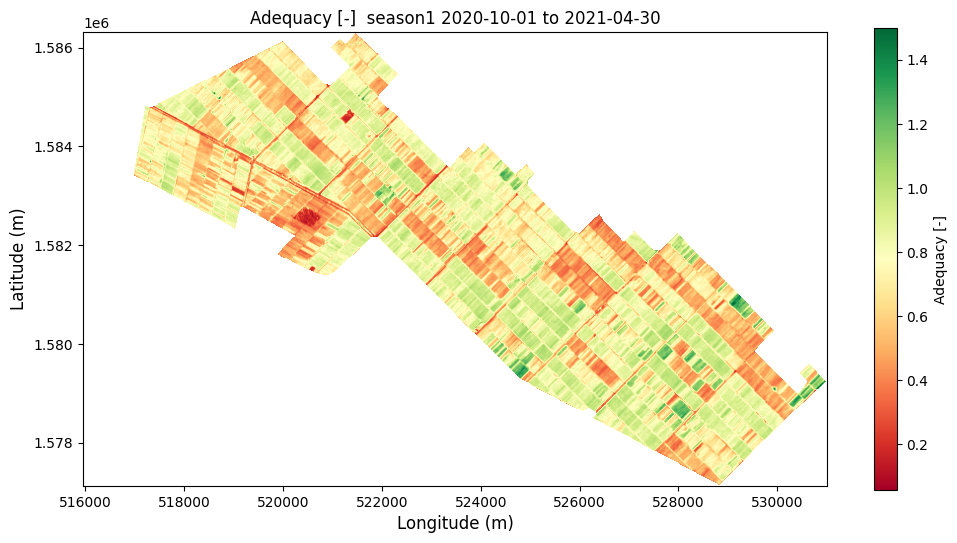

In [ ]:

for ETfh in AETI_fhs:
    try:
        AETI = riox.open_rasterio(ETfh)

        # Compute ETp as the 95th percentile of AETI
        ETp_value = np.nanpercentile(AETI.values, 95)
        ETp = xr.full_like(AETI, ETp_value)

        ETa_by_ETp = AETI / ETp

        # Get spatial extent
        spatial_extent = (ETa_by_ETp.x.min(), ETa_by_ETp.x.max(), ETa_by_ETp.y.min(), ETa_by_ETp.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'Adequacy')
        output_fn = os.path.join(output_folderAd, basename)
        ETa_by_ETp.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = ETa_by_ETp.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='Adequacy [-]')
        plt.xlabel('Longitude (m)', fontsize=12)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=12)
        plt.title('Adequacy [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")

## Step 3e - Calculate Relative water Deficit (RWD)
$RWD= 1-\frac{ET_a}{ET_x}$
<br/>${ET_x} = $ Can be ETp or 99 percentile of the actual evapotranspiration

In [ ]:
# Collecting GeoInfo such as projection, the x and y axis from the first file
in_fh = AETI_fhs[0]
AETI_extend = riox.open_rasterio(in_fh)
spatial_extent = (AETI_extend.x.min(), AETI_extend.x.max(), AETI_extend.y.min(), AETI_extend.y.max())

for i in range(len(AETI_fhs)):
    try:
        # Open the AETI file using rioxarray
        AETI = riox.open_rasterio(AETI_fhs[i])

        # Reshape the array
        AETI1_1D = np.reshape(AETI.values, AETI.shape[1] * AETI.shape[2])
        ETx = np.nanpercentile(AETI1_1D, 95)

        AETI_mean = np.nanmean(AETI.values)

        RWD = 1 - (AETI_mean / ETx)

        # Identify the date from the file name
        date = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ')

        print('Relative water deficit', date, '=', round(RWD, 2))

    except Exception as e:
        print(f"An error occurred with file {AETI_fhs[i]}: {e}")


Relative water deficit  season1 2020-10-01 to 2021-04-30 = 0.27


# Step 3f - Calculate Total Seasonal Biomass Production

Net Primary Production can be used to estimate total biomass production using the following formula:

    TBP = (NPP *22.222)/1000

The value 22.222 is to convert the NPP in gC/m^2 to biomass production in kg/ha. To convert to ton/ha the value is divided by 1000.

Review this script to check what each lines does.

In [46]:
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = "/content/drive/MyDrive/WaPOR_IPA/Data"
input_folderNPPs = os.path.join(dir_proj, dir_data, "NPP_season")
input_fhsNPPs = glob.glob(os.path.join(input_folderNPPs, '*.tif'))

output_folderBM = os.path.join(dir_proj, dir_data, "TBP_season")

# if the directory and folder does not exit, make one
if not os.path.exists(output_folderBM):
    os.makedirs(output_folderBM)
output_folderBM

'/content/drive/MyDrive/WaPOR_IPA/Data/TBP_season'

the mean & SD for  = 4.0 & 1.9


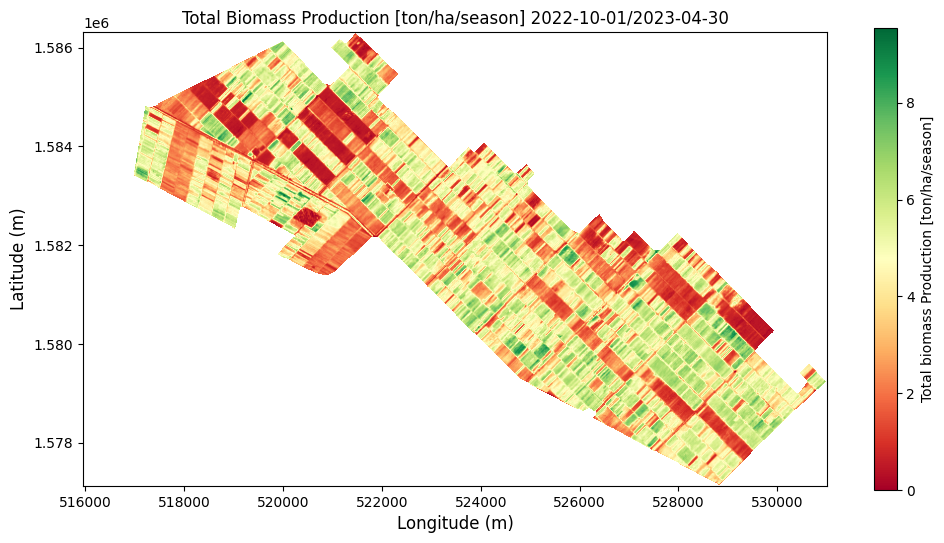

In [45]:
for i, season in enumerate(season_periods):
    NPP  = riox.open_rasterio(input_fhsNPPs[i], nan_values=True)
    TBP = (NPP * 22.222) / 1000  # Total biomass production, 1000 is to convert from kg to ton

    # save into output folder
    output_folder = output_folderBM
    out_fh = os.path.join(output_folder, 'TBP'+ '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    TBP.rio.to_raster(out_fh)

    # Plot the raster map
    seasonal = TBP
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))


    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Total biomass Production [ton/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Total Biomass Production [ton/ha/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ();

# Step 3g - Calculate Yield

In [37]:
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = "/content/drive/MyDrive/WaPOR_IPA/Data"
input_folderTBP = os.path.join(dir_proj, dir_data, "TBP_season")
input_fhsTBP = glob.glob(os.path.join(input_folderTBP, '*.tif'))

output_folderY = os.path.join(dir_proj, dir_data, "Yield_season")

# if the directory and folder does not exit, make one
if not os.path.exists(output_folderY):
    os.makedirs(output_folderY)
output_folderY

'/content/drive/MyDrive/WaPOR_IPA/Data/Yield_season'

## Crop Parameters

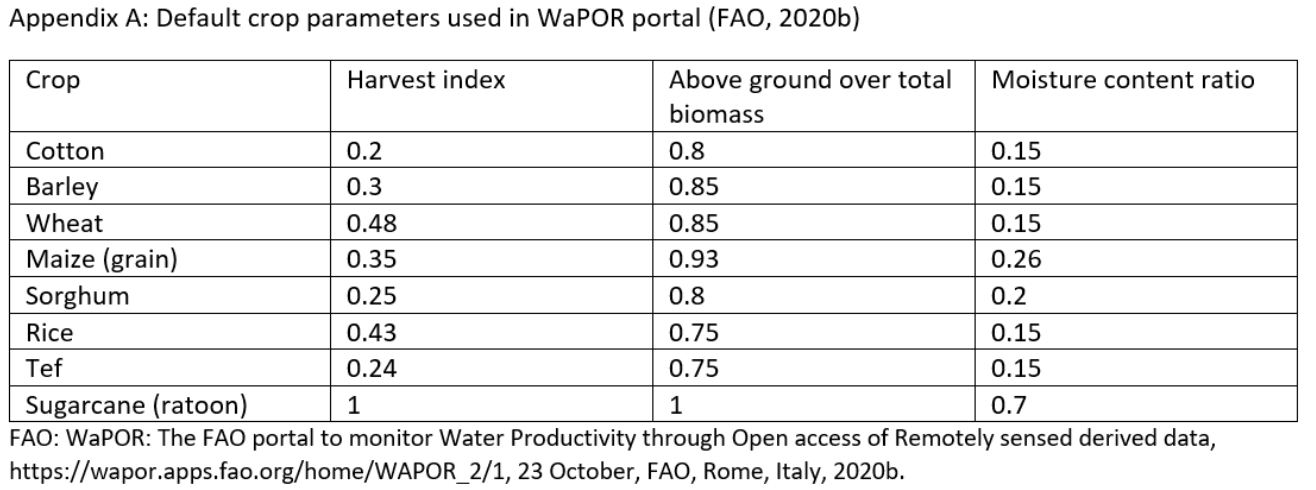

In [38]:
# Update the crop parameters specic to the crop
MC = 0.15  # moisture content, dry matter over freshbiomass
fc = 1.46  # Light use efficiency correction factor
AOT= 0.85  # above ground over total biomass production ratio(AOT)
HI = 0.48

the mean & SD for  = 2.8 & 1.4


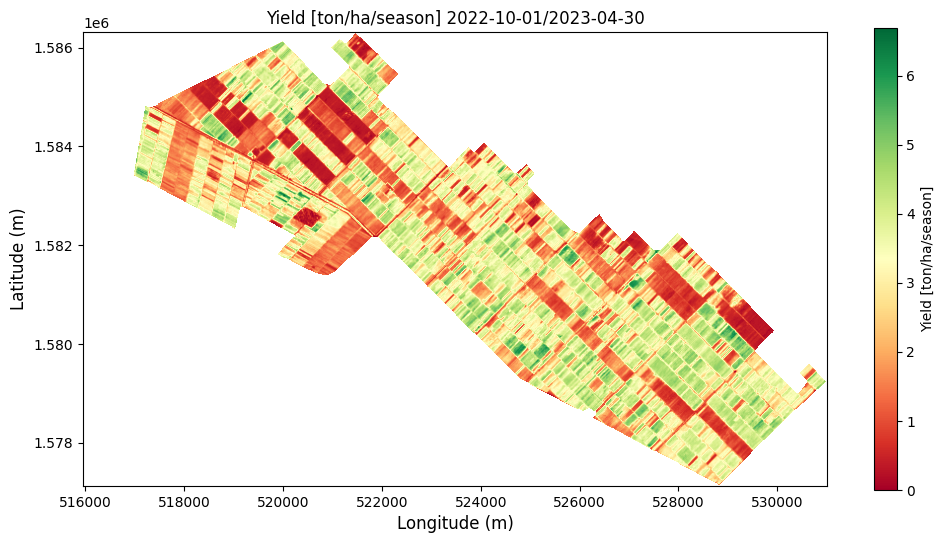

In [40]:
for i, season in enumerate(season_periods):
    TBP  = riox.open_rasterio(input_fhsTBP[i], nan_values=True)
    Y = TBP * 0.48
    Y = (AOT * fc * (TBP / (1 - MC)))* HI
    # save into output folder
    output_folder = output_folderY
    out_fh = os.path.join(output_folder, 'Yield'+ '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    TBP.rio.to_raster(out_fh)


    # Plot the raster map
    seasonal = Y
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))


    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Yield [ton/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Yield [ton/ha/season] ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ()
    ;

# Step 3h - Calculate Water Productivity

Finally we will calculate biomass water productivity, which is defined as the total biomass production divided by the AETI:

    WPb = TBP/AETI * 100

The multiplication with 100 is needed to correct the units, first convert TBP in ton/ha to kg/m^2 (divide by 10) and then AETI from mm/season to m/season (divide by 1000) so that the final unit of WPb is kg/m^3

In [43]:
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = "/content/drive/MyDrive/WaPOR_IPA/Data"
input_folder1  = os.path.join(dir_proj, dir_data, "AETI_season")
input_fhsET = glob.glob(os.path.join(input_folder1, '*.tif'))

input_folder2 = os.path.join(dir_proj, dir_data, "TBP_season")
input_fhsTBP  = glob.glob(os.path.join(input_folder2, '*.tif'))


output_folderWP = os.path.join(dir_proj, dir_data, "WP_season")
# if the directory and folder does not exit, make one
if not os.path.exists(output_folderWP):
    os.makedirs(output_folderWP)
output_folderWP

'/content/drive/MyDrive/WaPOR_IPA/Data/WP_season'

the mean & SD for  = 0.7 & 0.4


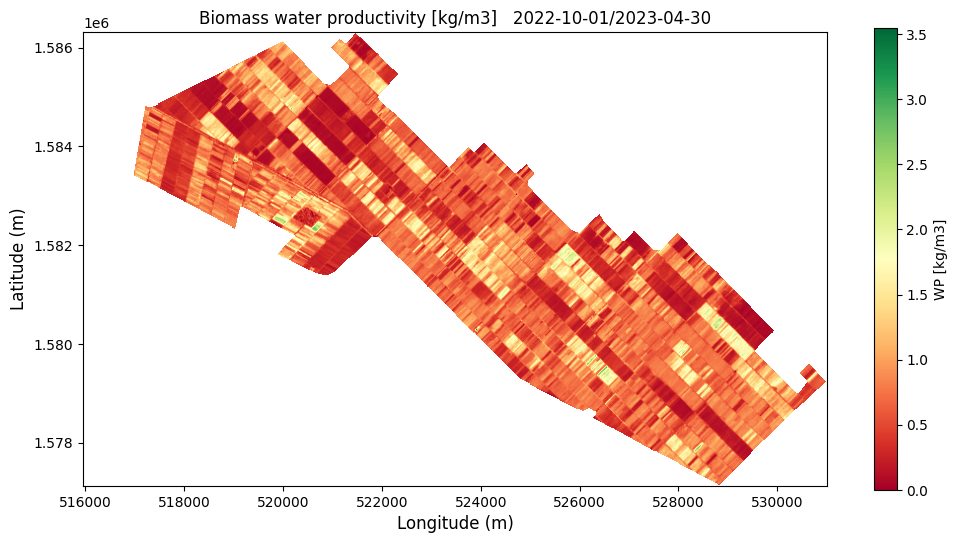

In [35]:
## Calculate the WP
for in_fhET, in_fhTBP in zip(input_fhsET, input_fhsTBP):
    AETI = riox.open_rasterio(in_fhET, nan_values=True)
    TBP = riox.open_rasterio(in_fhTBP, nan_values=True)
    WP  = TBP/AETI*100 # the multiplication with 100 is to correct the units to kg/m3 (from AETI in mm/season and TBP in ton/ha)


    # save into output folder
    output_folder = output_folderWP
    output_fh     = os.path.join(output_folder,'WP'+ '_' + season + '_' + season_periods[season]['SOS']+'_to_'+season_periods[season]['EOS']+ '.tif')
    WP.rio.to_raster(output_fh)


    # Plot the raster map
    seasonal = WP
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())


    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(2),'&',np.nanstd(seasonal).round(2))

    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='WP [kg/m3]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Biomass water productivity [kg/m3]   ' + season_periods[season]['SOS'] + '/' + season_periods[season]['EOS'])
    plt.clim()
    plt.show ()
    ;